# Logistic Regression and Stochastic Gradient Descent

## 1. Load the training set and validation set.
Import necessary packages and set parameters.

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.datasets import load_svmlight_file

# paremeters
epoch = 5
batch_size = 128

Load the training set and validation set.

In [7]:
def get_data(data_path, n_features):
    X, y = load_svmlight_file(data_path, n_features=n_features)
    X = X.toarray()
    b = np.ones((X.shape[0], 1))
    X = np.concatenate((b, X), axis=1)
    y = np.expand_dims(y, axis=1)
    y[np.where(y < 0)[0]] = 0
    return X, y

train_data_path = './a9a'
val_data_path = './a9a.t'
X_train, y_train = get_data(train_data_path, n_features=123)
X_val, y_val = get_data(val_data_path, n_features=123)

print('Training data set contains {} examples with {} dimensions'.format(X_train.shape[0], X_train.shape[1]))
print('Validation data set contains {} examples with {} dimensions'.format(X_val.shape[0], X_val.shape[1]))

Training data set contains 32561 examples with 124 dimensions
Validation data set contains 16281 examples with 124 dimensions


## 2. Initalize Logistic Regression model parameters
Initalize Logistic Regression parameters using normal distribution.

In [8]:
W1 = np.random.randn(X_train.shape[1], 1)
W2 = np.copy(W1)
W3 = np.copy(W1)
W4 = np.copy(W1)
W5 = np.copy(W1)

## 3. Optimization
Define function to plot loss and error.

In [9]:
def plot(train_loss, val_loss):
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='train', linewidth=2.0)
    ax.plot(val_loss, label='validation', linewidth=2.0)
    ax.set(xlabel='Iteration', ylabel='Loss')
    ax.grid()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)
    plt.show()

Define sigmoid function.

In [10]:
def sigmoid(W, X):
    return 1 / (1 + np.exp(-X.dot(W)))

### 3.1 Update model parameters using SGD
#### Logistic regression loss function:
$$L = \frac{1}{N} \sum_{i=1}^{N} \left[ \frac{\lambda}{2} \Vert W \Vert^2 + \max (0, 1 - y_i W^T x_i) \right]$$
#### The gradient with respect to the weight:
$$g = \frac{1}{m} X^T (\frac{1}{1 + e^{-W^TX}} - y)$$
#### Using SGD to update the weight:
$$W_{t+1} = W_t - \eta \cdot g ,$$
where the positive scalar $\eta$ is the learning rate.

In [11]:
eta = 0.1
def SGD_train(X_train, y_train, X_val, y_val, W):
    n, dim = X_train.shape
    val_n = X_val.shape[0]
    num_batch = int(math.ceil(n / float(batch_size)))
    train_loss = np.zeros((epoch * num_batch, ))
    val_loss = np.zeros((epoch * num_batch, ))
    for i in range(epoch):
        np.random.shuffle(X_train)
        for j in range(int(num_batch)):
            X_train_batch = X_train[j * batch_size: (j + 1) * batch_size, :]
            y_train_batch = y_train[j * batch_size: (j + 1) * batch_size, :]
            h = sigmoid(W, X_train_batch)
            val_h = sigmoid(W, X_val)
            train_loss[i * num_batch + j] = -1 / batch_size * np.sum(y_train_batch * np.log(h) + (1 - y_train_batch) * np.log(1 - h))
            val_loss[i * num_batch + j] = -1 / val_n * np.sum(y_val * np.log(val_h) + (1 - y_val) * np.log(1 - val_h))
            W_grad = X_train_batch.T.dot(h - y_train_batch) / batch_size
            W = W - eta * W_grad
    return train_loss, val_loss

train_loss, val_loss = SGD_train(X_train, y_train, X_val, y_val, W1)
plot(train_loss, val_loss)

### 3.2 Update model parameters using NAG
$$v_t = \gamma v_{t-1} + \eta \cdot \frac{\partial{L}}{\partial{(W - \gamma v_{t-1})}} $$
$$W_{t+1} = W_t - v_t$$
$\eta$ is the learning rate.

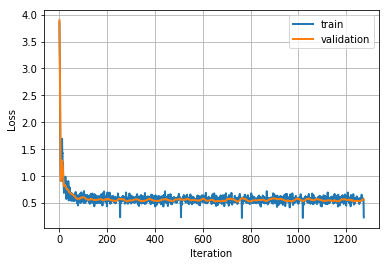

In [12]:
eta = 0.1
def NAG_train(X_train, y_train, X_val, y_val, W):
    n, dim = X_train.shape
    val_n = X_val.shape[0]
    num_batch = int(math.ceil(n / float(batch_size)))
    v = np.zeros((dim, 1))
    momentum = 0.9
    train_loss = np.zeros((epoch * num_batch, ))
    val_loss = np.zeros((epoch * num_batch, ))
    for i in range(epoch):
        np.random.shuffle(X_train)
        for j in range(int(num_batch)):
            X_train_batch = X_train[j * batch_size: (j + 1) * batch_size, :]
            y_train_batch = y_train[j * batch_size: (j + 1) * batch_size, :]
            h = sigmoid(W, X_train_batch)
            val_h = sigmoid(W, X_val)
            train_loss[i * num_batch + j] = -1 / batch_size * np.sum(y_train_batch * np.log(h) + (1 - y_train_batch) * np.log(1 - h))
            val_loss[i * num_batch + j] = -1 / val_n * np.sum(y_val * np.log(val_h) + (1 - y_val) * np.log(1 - val_h))
            h_new = sigmoid(W - momentum * v, X_train_batch)
            W_grad = X_train_batch.T.dot(h_new - y_train_batch) / batch_size
            v = momentum * v + eta * W_grad
            W = W - v
    return train_loss, val_loss

train_loss, val_loss = NAG_train(X_train, y_train, X_val, y_val, W2)
plot(train_loss, val_loss)

### 3.3 Update model parameters using RmsProp
$$E[g^2]_t = 0.9E[g^2]_{t - 1} + 0.1g_t^2$$
$$W_{t+1} = W_t - \frac{\eta}{\sqrt{E[g^2]_t + \epsilon}} g_t$$
$\eta$ is the learning rate.

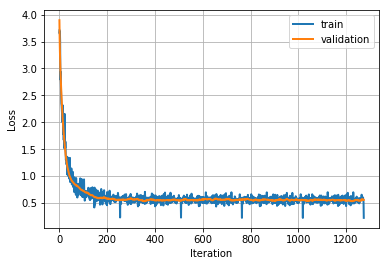

In [13]:
eta = 0.01
def RMSprop_train(X_train, y_train, X_val, y_val, W):
    n, dim = X_train.shape
    val_n = X_val.shape[0]
    num_batch = int(math.ceil(n / float(batch_size)))
    train_loss = np.zeros((epoch * num_batch, ))
    val_loss = np.zeros((epoch * num_batch, ))
    E_grad = np.zeros((dim, 1))
    for i in range(epoch):
        np.random.shuffle(X_train)
        for j in range(int(num_batch)):
            X_train_batch = X_train[j * batch_size: (j + 1) * batch_size, :]
            y_train_batch = y_train[j * batch_size: (j + 1) * batch_size, :]
            h = sigmoid(W, X_train_batch)
            val_h = sigmoid(W, X_val)
            train_loss[i * num_batch + j] = -1 / batch_size * np.sum(y_train_batch * np.log(h) + (1 - y_train_batch) * np.log(1 - h))
            val_loss[i * num_batch + j] = -1 / val_n * np.sum(y_val * np.log(val_h) + (1 - y_val) * np.log(1 - val_h))
            W_grad = X_train_batch.T.dot(h - y_train_batch) / batch_size
            E_grad = 0.9 * E_grad + 0.1 * np.square(W_grad)
            W = W - eta / np.sqrt(E_grad + np.spacing(1)) * W_grad
    return train_loss, val_loss

train_loss, val_loss = RMSprop_train(X_train, y_train, X_val, y_val, W3)
plot(train_loss, val_loss)

### 3.4 Update model parameters using Adadelta
$$E[g^2]_t = \gamma E[g^2]_{t-1} + (1 - \gamma) g_t^2$$
$$RMS[g]_t = \sqrt{E[g^2]_t + \epsilon}$$
$$\Delta W_t = - \frac{\eta}{RMS[g]_t} g_t$$
$$E[\Delta W^2]_t = \gamma E[\Delta W^2]_{t-1} + (1 - \gamma) \Delta W_t^2$$
$$RMS[\Delta W]_t = \sqrt{E[\Delta W^2]_t + \epsilon}$$
$$\Delta W_t = - \frac{RMS[\Delta W]_{t-1}}{RMS[g]_t}g_t $$
$$W = W + \Delta W$$
$\eta$ is the learning rate.

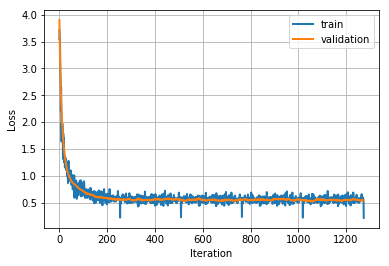

In [14]:
eta = 0.01
def AdaDelta_train(X_train, y_train, X_val, y_val, W):
    n, dim = X_train.shape
    val_n = X_val.shape[0]
    num_batch = int(math.ceil(n / float(batch_size)))
    train_loss = np.zeros((epoch * num_batch, ))
    val_loss = np.zeros((epoch * num_batch, ))
    momentum = 0.9
    E_grad = np.zeros((dim, 1))
    E_delta_W = np.zeros((dim, 1))
    for i in range(epoch):
        np.random.shuffle(X_train)
        for j in range(int(num_batch)):
            X_train_batch = X_train[j * batch_size: (j + 1) * batch_size, :]
            y_train_batch = y_train[j * batch_size: (j + 1) * batch_size, :]
            h = sigmoid(W, X_train_batch)
            val_h = sigmoid(W, X_val)
            train_loss[i * num_batch + j] = -1 / batch_size * np.sum(y_train_batch * np.log(h) + (1 - y_train_batch) * np.log(1 - h))
            val_loss[i * num_batch + j] = -1 / val_n * np.sum(y_val * np.log(val_h) + (1 - y_val) * np.log(1 - val_h))
            W_grad = X_train_batch.T.dot(h - y_train_batch) / batch_size
            E_grad = momentum * E_grad + (1 - momentum) * np.square(W_grad)
            RMS_grad = np.sqrt(E_grad + np.spacing(1))
            delta_W = - eta / RMS_grad * W_grad
            E_delta_W = momentum * E_delta_W + (1 - momentum) * np.square(delta_W)
            RMS_delta_W = np.sqrt(E_delta_W + np.spacing(1))
            W = W - RMS_delta_W / RMS_grad * W_grad
    return train_loss, val_loss

train_loss, val_loss = AdaDelta_train(X_train, y_train, X_val, y_val, W4)
plot(train_loss, val_loss)

### 3.5 Update model parameters using Adam
$$m_t = \beta_1 m_{t-1} + (1-\beta_1)g_t$$
$$v_t = \beta_2v_{t-1} + (1-\beta_2)g_t^2$$
$$\hat{m}_t = \frac{m_t}{1 - \beta_1^t}$$
$$\hat{v}_t = \frac{v_t}{1 - \beta_2^t}$$
$$W_{t+1} = W_t - \frac{\eta}{\sqrt{\hat{v}_t + \epsilon}} \hat{m}_t$$
$\eta$ is the learning rate.

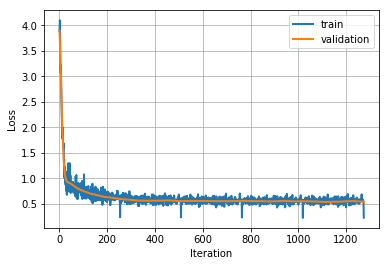

In [15]:
alpha = 0.01
def Adam_train(X_train, y_train, X_test, y_test, W):
    n, dim = X_train.shape
    test_n = X_test.shape[0]
    num_batch = int(math.ceil(n / float(batch_size)))
    train_loss = np.zeros((epoch * num_batch, ))
    test_loss = np.zeros((epoch * num_batch, ))
    beta_1 = 0.9
    beta_2 = 0.999
    m = np.zeros((dim, 1))
    v = np.zeros((dim, 1))
    for i in range(epoch):
        np.random.shuffle(X_train)
        for j in range(int(num_batch)):
            X_train_batch = X_train[j * batch_size: (j + 1) * batch_size, :]
            y_train_batch = y_train[j * batch_size: (j + 1) * batch_size, :]
            h = sigmoid(W, X_train_batch)
            test_h = sigmoid(W, X_test)
            train_loss[i * num_batch + j] = -1 / batch_size * np.sum(y_train_batch * np.log(h) + (1 - y_train_batch) * np.log(1 - h))
            test_loss[i * num_batch + j] = -1 / test_n * np.sum(y_test * np.log(test_h) + (1 - y_test) * np.log(1 - test_h))
            W_grad = X_train_batch.T.dot(h - y_train_batch) / batch_size
            m = beta_1 * m + (1 - beta_1) * W_grad
            v = beta_2 * v + (1 - beta_2) * np.square(W_grad)
            m_hat = m / (1 - beta_1)
            v_hat = v / (1 - beta_2)
            W = W - alpha / (np.sqrt(v_hat) + np.spacing(1)) * m_hat
    return train_loss, test_loss

train_loss, val_loss = Adam_train(X_train, y_train, X_val, y_val, W5)
plot(train_loss, val_loss)

## 4. Investigate the sensitiveness of the parametes
### 4.1 Investigate the sensitiveness of $\eta$ with SGD

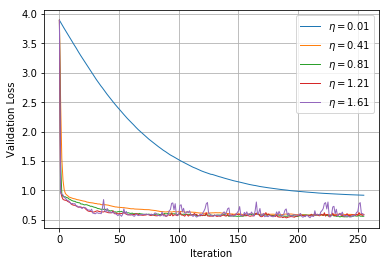

In [20]:
epoch = 2
batch_size = 256
eta_list = np.arange(0.01, 2, 0.4)
eta_list_detail = eta_list[1:-1]

num_eta = eta_list.size
fig, ax = plt.subplots()
ax.set_xlabel('Iteration')
ax.set_ylabel('Validation Loss')
ax.grid()
line_list = []
for i in range(num_eta):
    eta = eta_list[i].item()
    train_loss, val_loss = SGD_train(X_train, y_train, X_val, y_val, np.copy(W1))
    line, = ax.plot(val_loss, linewidth=1, label=r'$\eta = ${:.2f}'.format(eta_list[i]))
    line_list.append(line)
ax.legend(handles=line_list)
plt.show()
fig.savefig('figures/loss_vs_iteration_logistic_regression_SGD.pdf')

### 4.2 Investigate the sensitiveness of $\eta$ with NAG

In [21]:
epoch = 2
batch_size = 256
eta_list = np.arange(0.01, 1.4, 0.2)
eta_list_detail = eta_list[1:-1]

num_eta = eta_list.size
val_loss_last = np.zeros((num_eta, ))
fig, ax = plt.subplots()
ax.set_xlabel('Iteration')
ax.set_ylabel('Validation Loss')
ax.grid()
line_list = []
for i in range(num_eta):
    eta = eta_list[i].item()
    train_loss, val_loss = NAG_train(X_train, y_train, X_val, y_val, np.copy(W1))
    line, = ax.plot(val_loss, linewidth=1, label=r'$\eta = ${:.2f}'.format(eta_list[i]))
    line_list.append(line)
ax.legend(handles=line_list)
plt.show()
fig.savefig('figures/loss_vs_iteration_logistic_regression_NAG.pdf')

### 4.3 Investigate the sensitiveness of $\eta$ with RmsProp

In [22]:
epoch = 2
batch_size = 256
eta_list = np.arange(0.001, 0.12, 0.02)
eta_list_detail = eta_list[1:-1]

num_eta = eta_list.size
val_loss_last = np.zeros((num_eta, ))
fig, ax = plt.subplots()
ax.set_xlabel('Iteration')
ax.set_ylabel('Validation Loss')
ax.grid()
line_list = []
for i in range(num_eta):
    eta = eta_list[i].item()
    train_loss, val_loss = RMSprop_train(X_train, y_train, X_val, y_val, np.copy(W1))
    line, = ax.plot(val_loss, linewidth=1, label=r'$\eta = ${:.3f}'.format(eta_list[i]))
    line_list.append(line)
ax.legend(handles=line_list)
plt.show()
fig.savefig('figures/loss_vs_iteration_logistic_regression_RMSprop.pdf')

### 4.4 Investigate the sensitiveness of $\eta$ with Adadelta

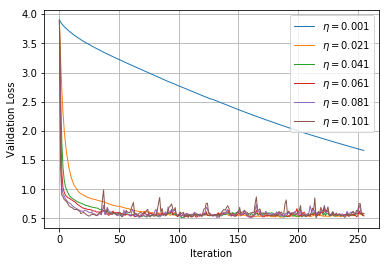

In [24]:
epoch = 2
batch_size = 256
eta_list = np.arange(0.001, 0.12, 0.02)
eta_list_detail = eta_list[1:-1]

num_eta = eta_list.size
val_loss_last = np.zeros((num_eta, ))
fig, ax = plt.subplots()
ax.set_xlabel('Iteration')
ax.set_ylabel('Validation Loss')
ax.grid()
line_list = []
for i in range(num_eta):
    eta = eta_list[i].item()
    train_loss, val_loss = AdaDelta_train(X_train, y_train, X_val, y_val, np.copy(W1))
    line, = ax.plot(val_loss, linewidth=1, label=r'$\eta = ${:.3f}'.format(eta_list[i]))
    line_list.append(line)
ax.legend(handles=line_list)
plt.show()
fig.savefig('figures/loss_vs_iteration_logistic_regression_Adadelta.pdf')

### 4.5 Investigate the sensitiveness of $\eta$ with Adam

In [28]:
epoch = 2
batch_size = 256
eta_list = np.arange(0.001, 0.12, 0.02)
eta_list_detail = eta_list[1:-1]

num_eta = eta_list.size
fig, ax = plt.subplots()
ax.set_xlabel('Iteration')
ax.set_ylabel('Validation Loss')
ax.grid()
line_list = []
for i in range(num_eta):
    eta = eta_list[i].item()
    train_loss, val_loss = Adam_train(X_train, y_train, X_val, y_val, np.copy(W1))
    line, = ax.plot(val_loss, linewidth=1, label=r'$\eta = ${:.3f}'.format(eta_list[i]))
    line_list.append(line)
ax.legend(handles=line_list)
plt.show()
fig.savefig('figures/loss_vs_iteration_logistic_regression_Adam.pdf')

### 4.6 Investigate the performance of different optimization algorithm

In [27]:
epoch = 2
batch_size = 256
eta_list = np.array([0.81, 0.41, 0.041, 0.041, 0.031])
function_list = [SGD_train, NAG_train, RMSprop_train, AdaDelta_train, Adam_train]
function_name_list = ['SGD', 'NAG', 'RMSprop', 'AdaDelta', 'Adam']

num_eta = eta_list.size
fig, ax = plt.subplots()
ax.set_xlabel('Iteration')
ax.set_ylabel('Validation Loss')
ax.grid()
line_list = []
for i in range(num_eta):
    eta = eta_list[i].item()
    train_loss, val_loss = function_list[i](X_train, y_train, X_val, y_val, np.copy(W1))
    line, = ax.plot(val_loss, linewidth=1, label='{}'.format(function_name_list[i]))
    line_list.append(line)
ax.legend(handles=line_list)
plt.show()
fig.savefig('figures/loss_vs_iteration_logistic_regression.pdf')